### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap
import sklearn
import timeit
import seaborn as sns
import os
from pathlib import Path

dataPath = str(Path(os.getcwd()).parent.absolute())+"/data"
figuresPath = str(Path(os.getcwd()).parent.absolute())+"/reports/figures"

In [2]:
sectors = pd.read_excel(dataPath+'/raw/sectors.xlsx', index_col=0, sheet_name="Sheet2") 

In [3]:
GMB_MKT_daily = pd.read_csv(dataPath+'/interim/marketGreenPortfolios.csv', index_col=0).loc[:,["MKT_GMB_BL|DAILY_RETURNS","MKT_GMB_RO|DAILY_RETURNS","MKT_GMB|DAILY_RETURNS"]]
# GMB_MKT_daily.head()
GMB_INDW_daily = pd.read_csv(dataPath+'/interim/industryWeightedGreenPortfolios.csv', index_col=0)[['IND_W_GREEN|DAILY_RETURNS','IND_W_BROWN|DAILY_RETURNS',"IND_W_GMB_BL|DAILY_RETURNS","IND_W_GMB_RO|DAILY_RETURNS","IND_W_GMB|DAILY_RETURNS"]]
#  GMB_INDW_daily.head()
MKT_daily = pd.read_csv(dataPath+'/interim/marketData.csv', index_col=0)["MKT|DAILY_RETURNS"]
# MKT_daily.head()
STOCKS_daily = pd.read_csv(dataPath+'/raw/stocksData.csv', index_col=0) 
#  STOCKS_daily.head()
FF_daily = pd.read_csv(dataPath+'/raw/ffData.csv', index_col=0)
# ff_ret.head()

IND_daily = pd.DataFrame()
for sector in sectors.index:
    IND_daily[str(sector)+"|DAILY_RETURNS"]=pd.read_csv(dataPath+"/interim/industries/industry"+str(sector)+'MarketData.csv', index_col=0)["MKT|DAILY_RETURNS"]
    IND_daily[str(sector)+"_BROWN_BL|DAILY_RETURNS"]=pd.read_csv(dataPath+"/interim/industries/industry"+str(sector)+'GreenPortfolios.csv', index_col=0)["MKT_BROWN_BL|DAILY_RETURNS"]
    IND_daily[str(sector)+"_BROWN_RO|DAILY_RETURNS"]=pd.read_csv(dataPath+"/interim/industries/industry"+str(sector)+'GreenPortfolios.csv', index_col=0)["MKT_BROWN_RO|DAILY_RETURNS"]
    IND_daily[str(sector)+"_BROWN|DAILY_RETURNS"] = (IND_daily[str(sector)+"_BROWN_RO|DAILY_RETURNS"]+IND_daily[str(sector)+"_BROWN_BL|DAILY_RETURNS"])/2
    IND_daily[str(sector)+"_GREEN_BL|DAILY_RETURNS"]=pd.read_csv(dataPath+"/interim/industries/industry"+str(sector)+'GreenPortfolios.csv', index_col=0)["MKT_GREEN_BL|DAILY_RETURNS"]
    IND_daily[str(sector)+"_GREEN_RO|DAILY_RETURNS"]=pd.read_csv(dataPath+"/interim/industries/industry"+str(sector)+'GreenPortfolios.csv', index_col=0)["MKT_GREEN_RO|DAILY_RETURNS"]
    IND_daily[str(sector)+"_GREEN|DAILY_RETURNS"] = (IND_daily[str(sector)+"_GREEN_RO|DAILY_RETURNS"]+IND_daily[str(sector)+"_GREEN_BL|DAILY_RETURNS"])/2


In [4]:
merged=pd.concat([FF_daily,MKT_daily,IND_daily,GMB_MKT_daily,GMB_INDW_daily],axis=1)
merged=merged.dropna()# drops the first row which contains NaN
# merged.head()

In [5]:
portfolios = ['MKT|DAILY_RETURNS',
            '10|DAILY_RETURNS',
            '15|DAILY_RETURNS',
            '20|DAILY_RETURNS',
            '25|DAILY_RETURNS',
            '30|DAILY_RETURNS',
            '35|DAILY_RETURNS',
            '40|DAILY_RETURNS',
            '45|DAILY_RETURNS',
            '50|DAILY_RETURNS',
            '55|DAILY_RETURNS',
            '60|DAILY_RETURNS',
            'IND_W_GREEN|DAILY_RETURNS',
            'IND_W_BROWN|DAILY_RETURNS']





In [6]:
GMB_INDW_daily

,IND_W_GREEN|DAILY_RETURNS,IND_W_BROWN|DAILY_RETURNS,IND_W_GMB_BL|DAILY_RETURNS,IND_W_GMB_RO|DAILY_RETURNS,IND_W_GMB|DAILY_RETURNS
Dates,,,,,
2016-09-13,NaN,NaN,NaN,NaN,NaN
2016-09-14,-0.269517,-0.078666,-0.221207,-0.160495,-0.190851
2016-09-15,0.980204,1.241376,-0.344024,-0.178322,-0.261173
2016-09-16,-0.393606,-0.310334,-0.065818,-0.100725,-0.083272
2016-09-19,0.125321,0.144951,-0.061852,0.022592,-0.019630
...,...,...,...,...,...
2022-11-29,0.235426,0.065952,0.253815,0.085133,0.169474
2022-11-30,2.910920,2.656160,0.274836,0.234685,0.254761
2022-12-01,-0.158658,0.111188,-0.397892,-0.141800,-0.269846


In [7]:
portfolioBetas=pd.DataFrame()
for portfolio in portfolios:
    X = merged[['Mkt-RF','SMB','HML','RMW','CMA','IND_W_GMB|DAILY_RETURNS']]
    X1= sm.add_constant(X)   
    y = merged[portfolio]-merged['RF']
    model= sm.OLS(y,X1).fit()
    portfolioBetas[portfolio]=[model.summary2().tables[1]["Coef."]["IND_W_GMB|DAILY_RETURNS"]]



In [8]:
portfolioBetas2 = pd.DataFrame()
for column in portfolioBetas:
    portfolioBetas2[column[:-14]] = portfolioBetas[column]  
    
portfolioBetas3 = pd.DataFrame()
for column in portfolioBetas2:
    if column == "MKT":
        portfolioBetas3[column]=portfolioBetas2[column]
    elif column == "IND_W_GREEN":
        portfolioBetas3["Green"]=portfolioBetas2[column]
    elif column == "IND_W_BROWN":
        portfolioBetas3["Brown"]=portfolioBetas2[column]
    else:
        portfolioBetas3[sectors["GICS Sector"][int(column)][:8]]=portfolioBetas2[column]


In [9]:
portfolioBetas3 = portfolioBetas3.transpose().sort_values(by=[0]).transpose()

In [10]:
portfolioBetas3

,Brown,Utilitie,Real Est,Material,Consumer,Industri,Health C,MKT,Financia,Informat,Energy,Green,Communic
0,-0.751926,-0.593353,-0.513505,-0.241087,-0.116735,-0.052062,-0.04124,0.081325,0.090753,0.140409,0.185735,0.248074,0.641741


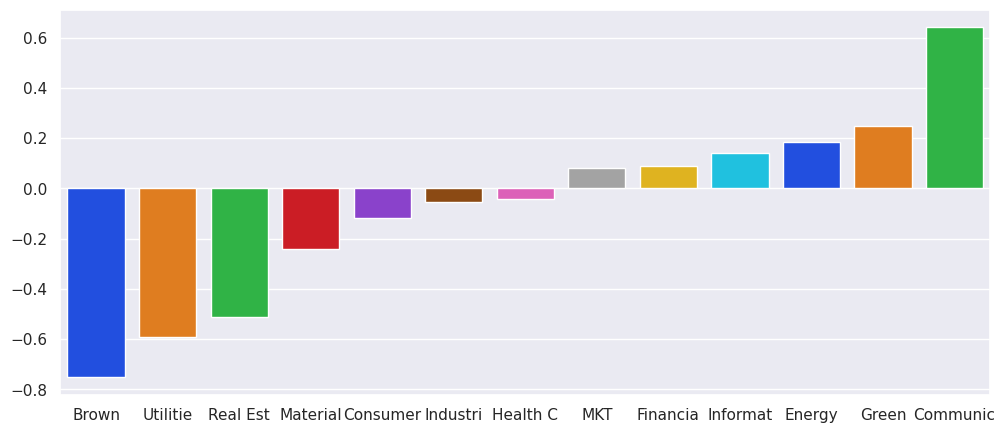

In [11]:
sns.set(rc={"figure.figsize":(12, 5)})
sns_plot = sns.barplot(data=portfolioBetas3, palette="bright")
fig = sns_plot.get_figure()
fig.savefig(figuresPath+"/betaCoefficients.png")